## Import required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
from timeit import default_timer as timer
from scipy.linalg import toeplitz 

## my own functions
from utils import moments_estimate, format_data, sample_PLN
import seaborn as sns 
import PLN

import torch
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"

## Read oaks data set

In [2]:
'''
Y = read_csv('oaks_counts.csv', sep=',').to_numpy()
O = read_csv('oaks_offsets.csv', sep=',').to_numpy()
data = format_data(counts = Y, offsets = np.log(O))
# Initialization of the variational parameters
M0, S0 = moments_estimate(Y, np.log(O))
'''

"\nY = read_csv('oaks_counts.csv', sep=',').to_numpy()\nO = read_csv('oaks_offsets.csv', sep=',').to_numpy()\ndata = format_data(counts = Y, offsets = np.log(O))\n\n\n\n\n# Initialization of the variational parameters\nM0, S0 = moments_estimate(Y, np.log(O))\n"

In [34]:
d = 4 # nb of cavariates
n = 1000; p = 200

In [35]:
torch.manual_seed(0)
true_Sigma = torch.from_numpy(toeplitz(0.9**np.arange(p)))
#true_Sigma = build_block_Sigma(p,4)
true_C = torch.cholesky(true_Sigma)
true_beta = torch.randn(d, p)

covariates = torch.rand((n,d))
O =  1+torch.zeros((n,p))

sample_model = sample_PLN()
Y,Z = sample_model.sample(true_Sigma,true_beta, O, covariates)

data = format_data(counts = Y, offsets = np.log(O.numpy()))

M0, S0 = moments_estimate(Y, np.log(O.numpy()))

/home/bastien/Documents/Stage/PLNpy/utils.py:20: RuntimeWarning: invalid value encountered in log
  return np.sum(v * np.log(v) - v + np.log(8 * v ** 3 + 4 * v ** 2 + v + 1/30)/6 + np.log(np.pi)/2)


<AxesSubplot:>

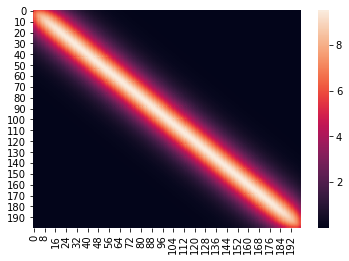

In [36]:
sns.heatmap(true_Sigma)

## Test various optimizer for standard PLN

In [38]:
# Instantiating PLN model with full covariance
myPLN = PLN.full_covariance(data)

### Nlopt solver with CCSAQ on profiled ELBO

In [39]:
start = timer()
# Optimization with the CCSA solver from NLopt
res_nlopt = myPLN.fit_profiled_variational_objective(M0, S0, solver = 'nlopt', ftol = 1e-16)
end = timer()
time_nlopt = end - start

Sigma_profiled = myPLN.Sigma
B_profiled = myPLN.B

KeyboardInterrupt: 

MSE :  15.380801731557654


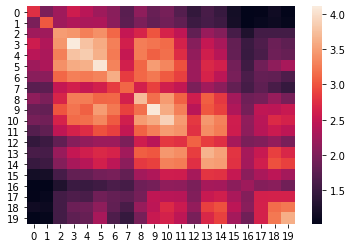

In [29]:
sns.heatmap(Sigma_profiled)
print('MSE : ', np.mean((Sigma_profiled-true_Sigma.numpy())**2))

### Pytorch solver with RProp and auto-grad on profiled ELBO

In [40]:
start = timer()
# Optimization with Rprop solver from Pytorch with autograd
res_torch = myPLN.fit_profiled_variational_objective(M0, S0, solver = 'torch', device = device, lr = 1, nsteps=100, ftol = 1e-3)
end = timer()
time_torch = end - start

Sigma_profiled_torch = myPLN.Sigma
B_profiled_torch = myPLN.B

MSE :  0.32909204353402627


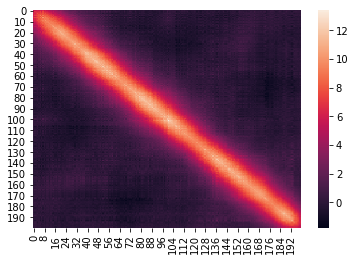

In [41]:
sns.heatmap(Sigma_profiled_torch)
print('MSE : ', np.mean((Sigma_profiled_torch-true_Sigma.numpy())**2))

### V-EM

In [ ]:
start = timer()
# Optimization with the CCSA solver from NLopt
res_VEM = myPLN.fit_variational_objective(M0, S0)
end = timer()
time_vem = end - start

Sigma_VEM = myPLN.Sigma
B_VEM = myPLN.B

MSE :  1.3922311581151956


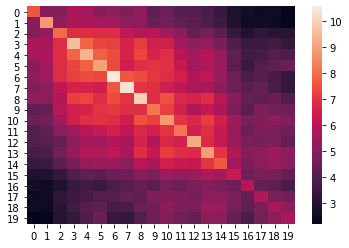

In [33]:
sns.heatmap(Sigma_VEM)
print('MSE : ', np.mean((Sigma_VEM-true_Sigma.numpy())**2))

## Some outputs

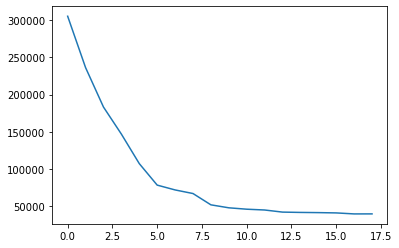

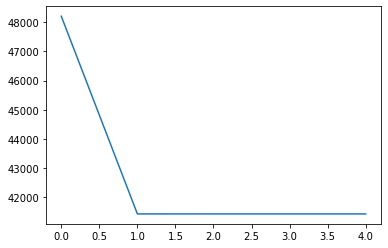

41110.78439741155
26112.19551330985
41427.51615847423
0.0870961399996304
0.058115510997595266
0.3610429309992469


In [8]:
plt.plot(res_torch['objective'][5:])
plt.show()
plt.plot(res_VEM['objective'])
plt.show()

print(res_nlopt['criterion'])
print(res_torch['criterion'])
print(res_VEM['criterion'])
print(time_nlopt)
print(time_torch)
print(time_vem)


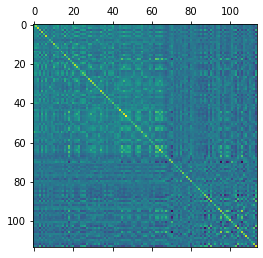

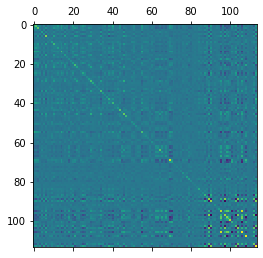

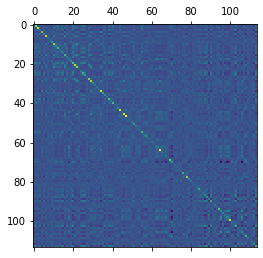

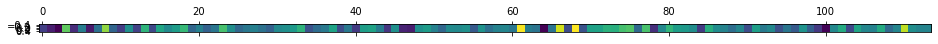

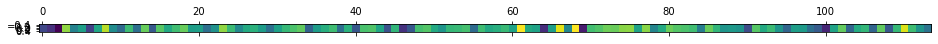

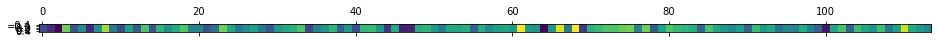

In [13]:
plt.matshow(Sigma_profiled)
plt.matshow(Sigma_profiled_torch)
plt.matshow(Sigma_VEM)
plt.matshow(B_profiled)
plt.matshow(B_profiled_torch)
plt.matshow(B_VEM)


In [ ]:
plt.matshow(Sigma_profiled_torch)